In [1]:
!apt update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xvf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [962 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ge

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import findspark
findspark.init()

In [35]:
import pyspark
import time
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql.types import StringType, FloatType, ArrayType
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, RegexTokenizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
spark = SparkSession.builder.appName('pj_1').getOrCreate()

## Đọc dữ liệu đã xử lý

In [7]:
data_new_1 = spark.read.csv('/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Project_1/Data_Agoda_raw/1.1.csv', header=True, inferSchema=True)
data_new_2 = spark.read.csv('/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Project_1/Data_Agoda_raw/1.2.csv', header=True, inferSchema=True)

In [8]:
data = data_new_1.union(data_new_2)
data.count()

41329

In [9]:
data.show(3,truncate=False)

+--------+-----------+-----------+--------------------------------------+-------------------------------+-----+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
data.select([count(when(isnull(c),c)).alias(c) for c in data.columns]).toPandas().T

,0
Hotel ID,0
Nationality,0
Group Name,0
Room Type,0
Stay Details,0
Score,0
Review Date,0
Body_pre,0
Body_pre_load,0
Body_pre_fea,0


In [ ]:
data.select([count(when(isnan(c),c)).alias(c) for c in data.columns]).toPandas().T

,0
Hotel ID,0
Nationality,0
Group Name,0
Room Type,0
Stay Details,0
Score,0
Review Date,0
Body_pre,0
Body_pre_load,0
Body_pre_fea,0


In [11]:
data_pre = data.dropna()
data_pre.count()

38669

In [12]:
data_pre = data_pre.withColumn('Score', regexp_replace(col('Score'), ',', '.').cast(FloatType()))
data_pre.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Room Type: string (nullable = true)
 |-- Stay Details: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Review Date: string (nullable = true)
 |-- Body_pre: string (nullable = true)
 |-- Body_pre_load: string (nullable = true)
 |-- Body_pre_fea: string (nullable = true)
 |-- Body_pre_fea_normi: string (nullable = true)
 |-- Body_pre_fea_precess: string (nullable = true)
 |-- Body_pre_fea_remove: string (nullable = true)



## Tạo cột year, month, stay từ cột Stay Details và drop các cột không cần

In [13]:
data_pre = data_pre.withColumn('year', regexp_extract(col('Stay Details'), r'năm (\d{4})', 1)) \
       .withColumn('month', regexp_extract(col('Stay Details'), r'Tháng (\d{1,2})', 1))\
       .withColumn('stay', regexp_extract(col('Stay Details'), r'Đã ở (\d{1})', 1))
data_pre = data_pre.select('Hotel ID', 'Nationality', 'Group Name', 'Room Type', 'Score', 'Body_pre_fea_remove', 'year', 'month', 'stay')

In [ ]:
data_pre.show(3)

+--------+-----------+-----------+--------------------+-----+--------------------+----+-----+----+
|Hotel ID|Nationality| Group Name|           Room Type|Score| Body_pre_fea_remove|year|month|stay|
+--------+-----------+-----------+--------------------+-----+--------------------+----+-----+----+
|     1_1|   Nhật Bản|    Cặp đôi|Phòng Deluxe 2 Gi...| 10.0|chủ_nhân đêm thân...|2023|    7|   3|
|     1_1|   Việt Nam|Đi công tác|Phòng Deluxe 2 Gi...| 10.0|lựa_chọn mường gi...|2022|    9|   1|
|     1_1|   Việt Nam|    Cặp đôi|Deluxe Hướng biển...|  9.2|phòng khách_sạn k...|2024|    6|   1|
+--------+-----------+-----------+--------------------+-----+--------------------+----+-----+----+
only showing top 3 rows



## Tạo cột 'Tag' chứa 'Positive'/'Negative'/'Neutral' làm label cho model

In [14]:
file = open('/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Project_1/files/positive_words.txt', 'r', encoding="utf8")
positive_words = file.read().split('\n')
file.close()

file = open('/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Project_1/files/negative_words.txt', 'r', encoding="utf8")
negative_words = file.read().split('\n')
file.close()

def find_posi_words(document):
    word_list = []

    for word in positive_words:
        if word in document:
            word_list.append(word)

    return word_list

def find_nega_words(document):
    word_list = []

    for word in negative_words:
        if word in document:
            word_list.append(word)

    return word_list

In [15]:
find_posiwords_udf = udf(find_posi_words, returnType=ArrayType(StringType()))
find_negawords_udf = udf(find_nega_words, returnType=ArrayType(StringType()))

data_pre = data_pre.withColumn('positive_words', find_posiwords_udf(col('Body_pre_fea_remove')))
data_pre = data_pre.withColumn('negative_words', find_negawords_udf(col('Body_pre_fea_remove')))

data_pre = data_pre.withColumn('positive_count', size(col('positive_words')))
data_pre = data_pre.withColumn('negative_count', size(col('negative_words')))

data_pre.show(3, truncate=False)

+--------+-----------+-----------+--------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+----+-----------------------------------------------------------+------------------------+--------------+--------------+
|Hotel ID|Nationality|Group Name |Room Type                             |Score|Body_pre_fea_remove                                                                                                                                                                                                                                                   |year|month|stay|positive_words                                             |negative_words          |positive_count|negative_count|
+--------+-----------+-----------+------------------

In [16]:
def sentiment_analysis(score, positive_count, negative_count):
    if score < 7.0:
        return 'Negative'
    elif score >= 9.0 and (positive_count - negative_count) > 0:
        return 'Positive'
    elif score >= 9.0 and (positive_count - negative_count) <= 0:
        return 'Neutral'
    elif score < 9.0 and (positive_count - negative_count) >= 0:
        return 'Neutral'
    elif score < 9.0 and (positive_count - negative_count) < 0:
        return 'Negative'


# Register the UDF
sentiment_analysis_udf = udf(sentiment_analysis, StringType())

# Apply the UDF to the DataFrame
data_pre = data_pre.withColumn('Tag', sentiment_analysis_udf(col('Score'), col('positive_count'), col('negative_count')))
data_pre.show(30)

+--------+-----------+------------------+--------------------+-----+--------------------+----+-----+----+--------------------+--------------------+--------------+--------------+--------+
|Hotel ID|Nationality|        Group Name|           Room Type|Score| Body_pre_fea_remove|year|month|stay|      positive_words|      negative_words|positive_count|negative_count|     Tag|
+--------+-----------+------------------+--------------------+-----+--------------------+----+-----+----+--------------------+--------------------+--------------+--------------+--------+
|     1_1|   Nhật Bản|           Cặp đôi|Phòng Deluxe 2 Gi...| 10.0|chủ_nhân đêm thân...|2023|    7|   3|[tuyệt_vời, thú_v...|                  []|             6|             0|Positive|
|     1_1|   Việt Nam|       Đi công tác|Phòng Deluxe 2 Gi...| 10.0|lựa_chọn mường gi...|2022|    9|   1|            [đầy_đủ]|            [ồn, hư]|             1|             2| Neutral|
|     1_1|   Việt Nam|           Cặp đôi|Deluxe Hướng biển...|  9

### Vẽ biểu đô xem 10 từ positive xuất hiện nhiều

In [ ]:
data = data_pre.toPandas()

<ipython-input-50-11a4a6110cd3>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=positive_words_df, palette='viridis')


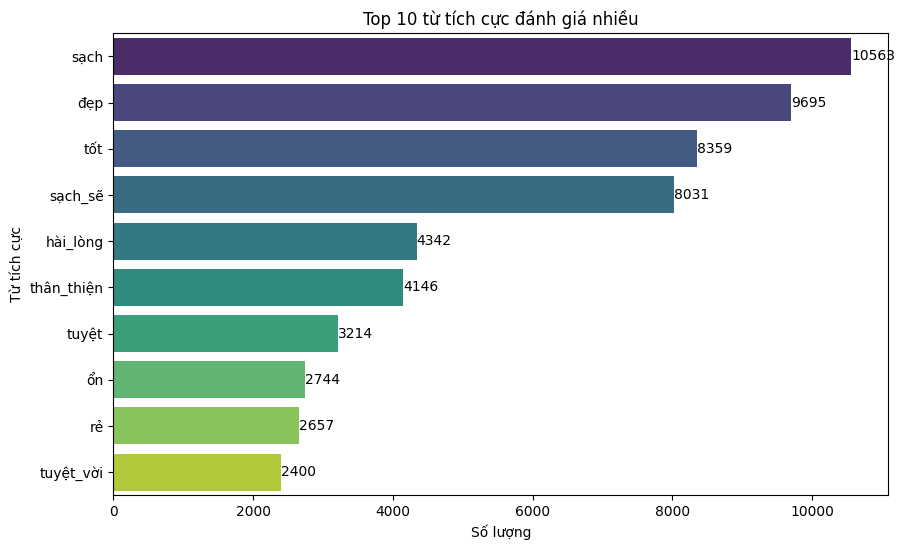

In [50]:
data['positive_words_str'] = data['positive_words'].apply(lambda x: ','.join(x))

# Gom tất cả các chuỗi lại thành một chuỗi văn bản lớn duy nhất
positive_words_str = data['positive_words_str'].tolist()

#Giữ các giá trị không phải '' và None
filtered_data = [text for text in positive_words_str if isinstance(text, str) and text.strip()]

#Tách cụm thành các từ riêng lẻ
separated_words = []
for phrase in filtered_data:
    separated_words.extend(phrase.split(','))

# Loại bỏ khoảng trắng thừa và kết hợp lại thành một chuỗi
cleaned_words = [word.strip() for word in separated_words]

#Đếm số lượng từ xuất hiện
word_counts = Counter(cleaned_words)

# Lấy 10 từ xuất hiện nhiều nhất
common_words = word_counts.most_common(10)

# Tạo DataFrame để vẽ biểu đồ
positive_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Word', data=positive_words_df, palette='viridis')
# Thêm số lượng trên đỉnh mỗi cột
for index, value in enumerate(positive_words_df['Count']):
    plt.text(value, index, str(value), color='black', ha="left", va="center")
plt.title('Top 10 từ tích cực đánh giá nhiều')
plt.xlabel('Số lượng')
plt.ylabel('Từ tích cực')
plt.show()

### Vẽ biểu đô xem 10 từ negative xuất hiện nhiều

<ipython-input-49-82eef7d5045c>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=negative_words_str, palette='viridis')


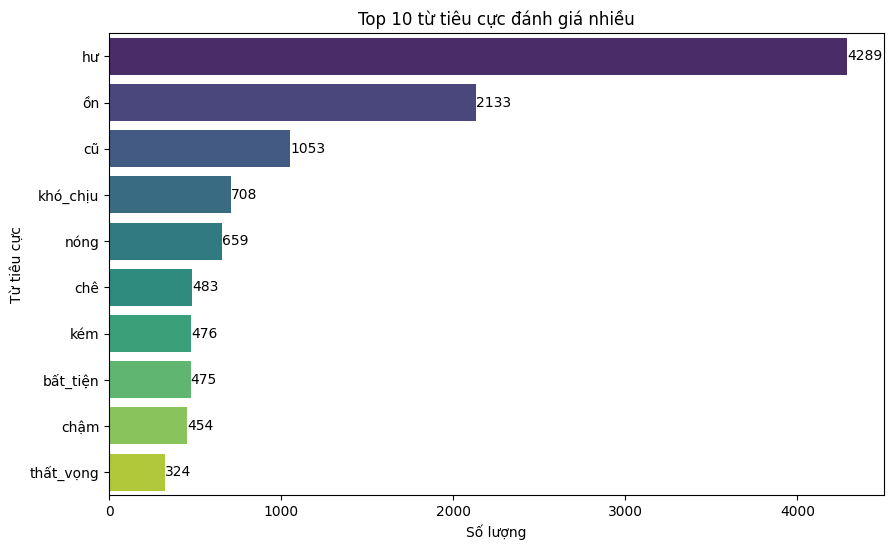

In [49]:
data['negative_words_str'] = data['negative_words'].apply(lambda x: ','.join(x))

# Gom tất cả các chuỗi lại thành một chuỗi văn bản lớn duy nhất
negative_words_str = data['negative_words_str'].tolist()

#Giữ các giá trị không phải '' và None
filtered_data = [text for text in negative_words_str if isinstance(text, str) and text.strip()]

#Tách cụm thành các từ riêng lẻ
separated_words = []
for phrase in filtered_data:
    separated_words.extend(phrase.split(','))

# Loại bỏ khoảng trắng thừa và kết hợp lại thành một chuỗi
cleaned_words = [word.strip() for word in separated_words]

#Đếm số lượng từ xuất hiện
word_counts = Counter(cleaned_words)

# Lấy 10 từ xuất hiện nhiều nhất
common_words = word_counts.most_common(10)

# Tạo DataFrame để vẽ biểu đồ
negative_words_str = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Word', data=negative_words_str, palette='viridis')
# Thêm số lượng trên đỉnh mỗi cột
for index, value in enumerate(negative_words_str['Count']):
    plt.text(value, index, str(value), color='black', ha="left", va="center")
plt.title('Top 10 từ tiêu cực đánh giá nhiều')
plt.xlabel('Số lượng')
plt.ylabel('Từ tiêu cực')
plt.show()

In [ ]:
data_pre.groupBy('Tag').count().show()

+--------+-----+
|     Tag|count|
+--------+-----+
|Positive|22453|
| Neutral|13615|
|Negative| 2601|
+--------+-----+



In [ ]:
tmp = data_pre.select('Group Name', 'Room Type', 'Tag', 'Body_pre_fea_remove')
tmp.show(3)

+-----------+--------------------+--------+--------------------+
| Group Name|           Room Type|     Tag| Body_pre_fea_remove|
+-----------+--------------------+--------+--------------------+
|    Cặp đôi|Phòng Deluxe 2 Gi...|Positive|chủ_nhân đêm thân...|
|Đi công tác|Phòng Deluxe 2 Gi...| Neutral|lựa_chọn mường gi...|
|    Cặp đôi|Deluxe Hướng biển...|Positive|phòng khách_sạn k...|
+-----------+--------------------+--------+--------------------+
only showing top 3 rows



In [ ]:
tmp.select([count(when(col(c).isNull(), c)).alias(c) for c in tmp.columns]).toPandas().T

,0
Group Name,0
Room Type,0
Tag,0
Body_pre_fea_remove,0


In [ ]:
tmp.select([count(when(isnan(c),c)).alias(c) for c in tmp.columns]).toPandas().T

,0
Group Name,0
Room Type,0
Tag,0
Body_pre_fea_remove,0


In [ ]:
tmp.printSchema()

root
 |-- Group Name: string (nullable = true)
 |-- Room Type: string (nullable = true)
 |-- Tag: string (nullable = true)
 |-- Body_pre_fea_remove: string (nullable = true)



## Chuẩn bị features, label

In [ ]:
regexTokenizer = RegexTokenizer(inputCol='Body_pre_fea_remove', outputCol='text_words', pattern='[^\\p{L}_]+')
data_tokenized = regexTokenizer.transform(tmp)

count_vec = CountVectorizer(inputCol='text_words', outputCol='c_vec', vocabSize=20000)
data_countvec = count_vec.fit(data_tokenized).transform(data_tokenized)

countTokens = udf(lambda words: len(words), IntegerType())
data_fe = data_countvec.withColumn('tokens',countTokens(col('text_words')))

In [ ]:
room_idx = StringIndexer(inputCol='Room Type', outputCol='Room_Type_idx')
data_fe = room_idx.fit(data_fe).transform(data_fe)

room_idx = StringIndexer(inputCol='Tag', outputCol='label')
data_fe = room_idx.fit(data_fe).transform(data_fe)

group_idx = StringIndexer(inputCol='Group Name', outputCol='Group_Name_idx')
data_fe = group_idx.fit(data_fe).transform(data_fe)

In [ ]:
#Assembler
assembler = VectorAssembler(inputCols=['c_vec','Room_Type_idx','Group_Name_idx','tokens'],
                           outputCol='features') # 6
data_assembler = assembler.transform(data_fe)

In [ ]:
data_assembler = data_assembler.select('features', 'label')
data_assembler.show(3,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                               |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(8017,[0,2,6,11,12,14,15,18,19,27,30,31,43,48,56,58,90,160,266,290,293,587,617,643,657,804,918,1252,2581,2687,3901,8014,8016],[3.0,2.0,

In [ ]:
data_assembler.select([count(when(isnull(c),c)).alias(c) for c in data_assembler.columns]).toPandas().T

,0
features,0
label,0


## Chuẩn bị train_data, test_data

### Xử lý imbalance bằng Oversampling

In [ ]:
import builtins
# Tính số lượng mẫu của từng lớp
class_0 = data_assembler.filter(col('label') == 0)
class_1 = data_assembler.filter(col('label') == 1)
class_2 = data_assembler.filter(col('label') == 2)

count_0 = class_0.count()
count_1 = class_1.count()
count_2 = class_2.count()

# Tìm lớp chiếm thiểu số
max_count = builtins.max(count_0, count_1, count_2)

# Tạo mẫu ngẫu nhiên từ các lớp chiếm đa số với kích thước bằng lớp chiếm thiểu số
sampled_class_0 = class_0.sample(withReplacement=True, fraction=max_count / count_0)
sampled_class_1 = class_1.sample(withReplacement=True, fraction=max_count / count_1)
sampled_class_2 = class_2.sample(withReplacement=True, fraction=max_count / count_2)

# Kết hợp các lớp lại
final_data = sampled_class_0.union(sampled_class_1).union(sampled_class_2)

In [ ]:
final_data.count()

67332

In [ ]:
final_data.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|22472|
|  1.0|22473|
|  2.0|22387|
+-----+-----+



In [ ]:
final_data = final_data.dropna()

In [ ]:
train_data, test_data = final_data.randomSplit([0.8,0.2])

In [ ]:
train_data.show(3,False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                          |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(8017,[0,1,2,3,4,5,6,8,10,15,27,37,46,109,111,146,177,224,248,706,8014,8015,8016],[1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,33.0,2.0,22.0])|0.0  |
|(8017,[0,1,2,3,4,5,6,8,10,15,27,37,46,109,111,146,177,224,248,706,8014,8015,8016],[1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,33.0,2.0,22.0])|0.0  |
|(8017,[0,1,2,3,4,5,6,8,10,15,27,37,46,109,111,146,177,224,248,70

In [ ]:
train_data.dtypes

[('features', 'vector'), ('label', 'double')]

In [ ]:
train_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|             53958|
|   mean|0.9996293413395604|
| stddev|0.8164586650210477|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



In [ ]:
test_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|             13374|
|   mean|0.9951398235382085|
| stddev|0.8153670687828908|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



## Xây dựng model với train_data

In [ ]:
detree = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxBins=1024)
randomtree = RandomForestClassifier(featuresCol='features', labelCol='label', maxBins=1024)
lg = LogisticRegression(featuresCol='features', labelCol='label')

In [ ]:
start_time = time.time()
detree_model = detree.fit(train_data)
end_time = time.time()
time_detree = end_time - start_time

In [ ]:
start_time = time.time()
randomtree_model = randomtree.fit(train_data)
end_time = time.time()
time_random = end_time - start_time

In [ ]:
start_time = time.time()
lg_model = lg.fit(train_data)
end_time = time.time()
time_lg = end_time - start_time

## Đánh giá model với test_data


In [ ]:
detree_test_model = detree_model.transform(test_data)
detree_test_model.select('prediction', 'label').show(3)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 3 rows



In [ ]:
randomtree_test_model = randomtree_model.transform(test_data)
randomtree_test_model.select('prediction', 'label').show(3)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 3 rows



In [ ]:
lg_test_model = lg_model.transform(test_data)
lg_test_model.select('prediction', 'label').show(3)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 3 rows



## Dùng Multiclass để tính accuracy

In [ ]:
acc = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [ ]:
detree_acc = acc.evaluate(detree_test_model)
randomtree_acc = acc.evaluate(randomtree_test_model)
lg_acc = acc.evaluate(lg_test_model)

## Dùng Binary để tính auc

In [ ]:
auc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')

In [ ]:
detree_auc = auc.evaluate(detree_test_model)
randomtree_auc = auc.evaluate(randomtree_test_model)
lg_auc = auc.evaluate(lg_test_model)

## Đánh giá model

In [ ]:
# Accuracy
print('DecisionTree\n')
print('Accuracy: ', detree_acc, 'AUC: ', detree_auc, 'Time: ', time_detree)
print('------------------------------------------------------------------')
print('RandomForest\n')
print('Accuracy: ', randomtree_acc, 'AUC: ', randomtree_auc, 'Time: ', time_random)
print('------------------------------------------------------------------')
print('LogisticRegression\n')
print('Accuracy: ', lg_acc, 'AUC: ', lg_auc, 'Time: ', time_lg)

DecisionTree

Accuracy:  0.5851652459997009 AUC:  0.7402772065509716 Time:  162.59631824493408
------------------------------------------------------------------
RandomForest

Accuracy:  0.626514131897712 AUC:  0.7898377102806367 Time:  122.7904577255249
------------------------------------------------------------------
LogisticRegression

Accuracy:  0.9099745775385075 AUC:  0.9397400179454471 Time:  123.14923095703125


## Chọn mô hình LogisticRegression vì cả Accuracy và AUC đều cao hơn 2 model còn lại